In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm


import sys
sys.path.append('../utils')
from utils import *

In [211]:
combined_df = retrieve_data()
combined_df

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489
...,...,...,...,...,...,...,...,...
248,2024-10-21,272.90,17.7575,126.65,31.1486,526.2,14.1699,0.6532
249,2024-10-22,272.20,18.2963,126.95,30.9890,520.4,14.7228,0.6544
250,2024-10-23,277.20,17.6974,126.05,31.3139,519.6,14.0134,0.6448
251,2024-10-24,279.80,17.7883,128.45,31.6005,520.6,14.4540,0.6213


In [212]:
combined_df = retrieve_data()
np.random.seed(42)
n_days = 252
dt = 1 / n_days
close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())

# Heston Stochastic Volatility Model 

only use constant interest rate r + does not incorporate option prices into the calibration process.

!!! calibrate based solely on historical stock price data, particularly the realized volatility of returns.

options data need to be collect more on daily basis from 2024/25/07 to 024/25/10.
i only collected on quaterly basis so now cannot right

In [213]:
vol = log_returns.rolling(window=30).var() * n_days
vol


,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
...,...,...,...
248,0.020141,0.118830,0.008371
249,0.019935,0.118104,0.009412
250,0.022582,0.118542,0.009246
251,0.018368,0.120691,0.009082


In [214]:
vol.mean()

ROG_Last_Price     0.040053
CFR_Last_Price     0.080205
ZURN_Last_Price    0.019759
dtype: float64

In [215]:
vol.iloc[0]

ROG_Last_Price    NaN
CFR_Last_Price    NaN
ZURN_Last_Price   NaN
Name: 1, dtype: float64

In [216]:
def objective(x):
    a = x ** 2 - 1
    return a

In [217]:
bounds = [(0.1, 10.0),  # kappa
          (0.001, 0.5),  # theta
          (0.01, 1.0),   # sigma
          (-0.99, 0.99)] # rho
            
result = minimize(objective, 
                  x0=[100],
                  bounds=[(-np.inf, np.inf)],
                  method='L-BFGS-B')

In [218]:
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.0
        x: [-2.149e-09]
      nit: 3
      jac: [ 1.110e-08]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [219]:
sys.path.append('./linh')
from option import *

In [221]:
import os
os.walk(output_directory + 'cleaned')

<generator object _walk at 0x7f14a384d8b0>

In [223]:
files = ['rog_call.csv', 'cfr_call.csv', 'zurn_call.csv']

In [224]:
options = pd.DataFrame(columns=['maturity', 'strike', 'price', 'IV', 'day', 'month', 'year', 'product'])
for i, f in enumerate(files):
    for file in next(os.walk(input_directory + 'cleaned'))[1]:
        data = pd.read_csv(f'../data/option_data/cleaned/{file}/' + f)
        data['day'] = file[:2]
        data['month'] = file[2:4]
        data['year'] = file[4:]
        data['product'] = tickers[i]
        options = pd.concat([options, data])




/tmp/ipykernel_4759/335833525.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  options = pd.concat([options, data])


In [225]:
options = options.sort_values(['product', 'month', 'day', 'maturity'])

In [226]:
options

,maturity,strike,price,IV,day,month,year,product
0,0.156057,124,9.674999,24.402237,25,07,2024,CFR_Last_Price
1,0.156057,126,8.200000,23.955641,25,07,2024,CFR_Last_Price
2,0.156057,128,6.850000,23.466326,25,07,2024,CFR_Last_Price
3,0.156057,130,5.600000,22.889894,25,07,2024,CFR_Last_Price
4,0.156057,132,4.515000,22.497936,25,07,2024,CFR_Last_Price
...,...,...,...,...,...,...,...,...
49,0.229979,520,13.550000,14.122618,25,10,2024,ZURN_Last_Price
50,0.229979,540,5.600000,13.379794,25,10,2024,ZURN_Last_Price
51,0.229979,560,1.720000,12.748696,25,10,2024,ZURN_Last_Price
52,0.229979,580,1.505000,16.218067,25,10,2024,ZURN_Last_Price


In [227]:
from lmfit import Parameters, minimize

In [228]:
options[options['product']=='CFR_Last_Price']

,maturity,strike,price,IV,day,month,year,product
0,0.156057,124,9.674999,24.402237,25,07,2024,CFR_Last_Price
1,0.156057,126,8.200000,23.955641,25,07,2024,CFR_Last_Price
2,0.156057,128,6.850000,23.466326,25,07,2024,CFR_Last_Price
3,0.156057,130,5.600000,22.889894,25,07,2024,CFR_Last_Price
4,0.156057,132,4.515000,22.497936,25,07,2024,CFR_Last_Price
...,...,...,...,...,...,...,...,...
43,0.229979,130,7.125000,30.834446,25,10,2024,CFR_Last_Price
44,0.229979,135,5.060000,30.493761,25,10,2024,CFR_Last_Price
45,0.229979,140,3.480000,30.214775,25,10,2024,CFR_Last_Price
46,0.229979,145,2.350000,30.146441,25,10,2024,CFR_Last_Price


In [229]:
combined_df.iloc[0]['Date'].strftime('%Y-%m-%d')

'2023-10-25'

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

class HestonModelCalibration:
    def __init__(self, current_id, data, n_days=252):
        self.current_id = current_id
        self.data = data
        self.n_days = n_days
        self.dt = 1 / n_days
        self.tickers = data.columns
        self.log_returns = np.log((data / data.shift(1)).dropna())
        
    def calculate_realized_vol(self, window_size=30):
        """Calculate realized volatility for initial variance"""
        return self.log_returns.rolling(window=window_size).var() * self.n_days
    
    def estimate_correlation_matrix(self, window_size=30):
        """Estimate correlation matrix from historical data"""
        return self.log_returns.iloc[-window_size:].corr().values
    def func_heston(self, St, K, r, T, sigma, kappa, theta, v0, rho, lambda_):
        

        # logger_yq.info(f"Final result: {result}")
        b1 = kappa + lambda_ - rho * sigma * r
        b2 = kappa + lambda_
        rate = r
        prod = rho * sigma * 1j * r
        d1 = np.sqrt((prod - b1)**2 - sigma ** 2 * (1j * r - (1j)**2))
        d2 = np.sqrt((prod - b2)**2 + sigma ** 2 * (1j * r - (1j)**2))
        g1 = (b1 - prod + d1) / (b1 - prod - d1)
        g2 = (b2 - prod + d2) / (b2 - prod - d2)

        c1 = r * 1j * rate * T + kappa * theta / (sigma ** 2) * (b1 - prod + d1) * T - 2 * np.log((1 - g1 * np.exp(d1 * T)) / (1 - g1))
        c2 = r * 1j * rate * T + kappa * theta / (sigma ** 2) * (b2 - prod + d2) * T - 2 * np.log((1 - g2 * np.exp(d2 * T)) / (1 - g2))

        d1 = (b1 - prod + d1) / sigma ** 2 * (1 - g1 * np.exp(d1 * T)) / (1 - g1)
        d2 = (b2 - prod + d2) / sigma ** 2 * (1 - g2 * np.exp(d2 * T)) / (1 - g2)

        res1 = St ** (r * 1j) * np.exp(c1 + d1 * v0)
        res2 = St ** (r * 1j) * np.exp(c2 + d2 * v0)
        return res1, res2


         
    def price_heston_mid(self, St, K, r, T, sigma, kappa, theta, v0, rho, lambda_):

        from scipy.integrate import quad

        res1, res2 = func_heston(St, K, r, T, sigma, kappa, theta, v0, rho, lambda_)
        integrand1 = lambda r: np.real(np.exp(-r * 1j * np.log(K)) * res1 / (r * 1j))
        integrand2 = lambda r: np.real(np.exp(-r * 1j * np.log(K)) * res2 / (r * 1j))
        integral1, _ = quad(integrand1, 0, np.inf)
        integral2, _ = quad(integrand2, 0, np.inf)
        
        C = St * (1/2 + 1/np.pi * integral1) - K * np.exp(-r * T) * (1/2 + 1/np.pi * integral2)
        return C

        
    def calibrate_heston_parameters(self, window_size=30):
        """
        Calibrate Heston model parameters using historical data
        Returns dict with parameters for each asset
        """
        model_params = {}
        for i, ticker in enumerate(self.tickers):
            # Initial estimates based on historical data
            # vol = self.calculate_realized_vol()[ticker].dropna()
            
            # def objective(x):
            #     kappa, theta, sigma, rho = x
            #     var_pred = theta + (vol.iloc[0] - theta) * np.exp(-kappa * np.arange(len(vol)) * self.dt)
            #     # ko tune cho sigma rho
            #     return np.mean((var_pred - vol)**2)
            # # variance_paths[k, i, j] = (v_prev + 
            # #             kappa[k] * (theta[k] - v_prev) * dt + 
            # #             sigma[k] * np.sqrt(v_prev * dt) * dw_s[k * 2 + 1, j] * chol_corr[k * 2 + 1][k * 2 + 1])
            # bounds = [(0.1, 10.0),  # kappa
            #          (0.001, 0.5),  # theta
            #          (0.01, 1.0),   # sigma
            #          (-0.99, 0.99)] # rho
            option_date = options['year'].astype(str) + '-' + options['month'].astype(str) + '-' + options['day'].astype(str)
            date = combined_df.iloc[self.current_id]['Date'].strftime('%Y-%m-%d')
            volatility_surface = options[(options['product']==ticker) & (option_date==date)]
            maturities = volatility_surface['maturity'].astype('float')
            strikes = volatility_surface['strike'].astype('float')
            price = volatility_surface['price'].astype('float')
            rates = 0.01107
                    
            params = Parameters()
            params.add('kappa', value=0.1, min = 0.001, max = 10)
            params.add('theta', value=0.1, min = 0.001, max = 0.1)
            params.add('v0', value=0.1, min = 0.001, max = 0.1)
            params.add('rho', value=0.1, min = -1, max = 1.0)
            params.add('sigma', value=0.1, min = 0.001, max = 0.5)
            params.add('lambda', value=0.1, min = -1, max = 1)

            objective = lambda paramVect: (price - self.price_heston_mid(self.data.iloc[self.current_id][ticker], 
                                                                        strikes,  
                                                                        rates, 
                                                                        maturities, 
                                                                        paramVect['sigma'].value,                         
                                                                        paramVect['kappa'].value,
                                                                        paramVect['theta'].value,
                                                                        paramVect['v0'].value,
                                                                        paramVect['rho'].value/(price + 1e-8),
                                                                        paramVect['lambda'].value))

            result = minimize(objective, 
                              params,
                              method='leastsq',
                              max_nfev=10,
                              ftol=1e-6)
            dicts = result.params.valuesdict()
            model_params[ticker] = {
                'kappa': dicts['kappa'],
                'theta': dicts['theta'],
                'sigma': dicts['sigma'],
                'rho': dicts['rho'],
                'v0': dicts['v0']
            }
        return model_params

def MultivariateHestonSimulation(
    s0,
    tickers,
    dt,
    calibrated_params,
    correlation_matrix,
    n_paths=1000,
    last_id=287,
    current_id=187,
    window_size=30,
    variance_reduction='av',
    method='euler'
    r=0.01
    ):
    
    if variance_reduction not in ['av', None]:
        raise ValueError('Supported variance reduction method is av')
    if method not in ['euler', 'qe']:
        raise ValueError("Supported discretization schemes are 'euler' and 'qe'")
    n_assets = len(tickers)
    T = dt * (last_id - current_id)
    n_steps = int(T / dt)
    
    # Initialize arrays
    result = np.zeros((n_assets, n_paths, n_steps))
    variance_paths = np.zeros((n_assets, n_paths, n_steps))
    
    # Extract parameters for each asset
    kappa = np.array([calibrated_params[t]['kappa'] for t in tickers])
    theta = np.array([calibrated_params[t]['theta'] for t in tickers])
    sigma = np.array([calibrated_params[t]['sigma'] for t in tickers])
    rho = np.array([calibrated_params[t]['rho'] for t in tickers])
    
    # Get initial variances
    v0 = {t: calibrated_params[t]['v0'] for t in tickers}
    # Ensure correlation matrix is 2D numpy array
    if isinstance(correlation_matrix, pd.DataFrame):
        correlation_matrix = correlation_matrix.values
        
    # Cholesky decomposition for correlated Brownian motions
    
        # s1 s2 s3
#     s1  1  s1s2 s1s3
#     s2 s1s2 1  s2s3
#     s3

#     correlation matrix 6x6 (only si-sj and si-vi non-zero)
#     s1          v1          s2          v2          s3          v3
# s1   1          rho_s1v1    rho_s1s2    0           rho_s1s3    0
# v1   rho_s1v1   1           rho_s2v1
# s2   rho_s1s2   rho_s2v1    1
# v2   0
# s3   rho_s1s3
# v3   0

# ==> simulate s1, s2, s3, v1, v2, v3 with 6 different z
    r1, r2, r3 = rho[0], rho[1], rho[2]
    r12 = correlation_matrix[0][1]
    r23 = correlation_matrix[1][2]
    r13 = correlation_matrix[0][2]
    correlation_matrix = np.array([[1, r1, r12, r2*r12, r13, r3*r13],
                                   [r1, 1, r1*r12, r1*r2*r12, r1*r13, r1*r3*r13],
                                   [r12, r1*r12, 1, r2, r23, r3*r23],
                                   [r2*r12, r1*r2*r12, r2, 1, r2*r23, r2*r3*r23],
                                   [r13, r1*r13, r23, r2*r23, 1, r3],
                                   [r3*r13, r1*r3*r13, r2*r23, r2*r3*r23, r3, 1]]) 
    
    

        
    try:
        chol_corr = np.linalg.cholesky(correlation_matrix)
    except np.linalg.LinAlgError:
        # If matrix is not positive definite, adjust it
        correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2  # Ensure symmetry
        min_eig = np.min(np.real(np.linalg.eigvals(correlation_matrix)))
        if min_eig < 0:
            correlation_matrix -= min_eig * np.eye(correlation_matrix.shape[0])  # Shift eigenvalues if needed
        try:
            # Try Cholesky again on the adjusted matrix
            chol_corr = np.linalg.cholesky(correlation_matrix)
        except np.linalg.LinAlgError:
            # If still not positive definite, add a small identity matrix (regularization)
            epsilon = 1e-8
            correlation_matrix += epsilon * np.eye(correlation_matrix.shape[0])
            chol_corr = np.linalg.cholesky(correlation_matrix)

    if method=='qe': # using the qe scheme, we have to apply correlation correction to our correlation matrix
        q = np.zeros((n_assets * 2, n_assets * 2))
        for i in range(len(n_assets)):
            q[i * 2][i * 2] = np.sqrt(1 - rho[i]**2)
            q[i * 2][i * 2 + 1] = rho[i] ** 2
            q[i * 2 + 1][i * 2 + 1] = 1
        
        q_inverse = np.linalg.inv(q)
        chol_corr = np.matmul(q_inv, chol_corr)
    
    paths_to_simulate = n_paths // 2 if variance_reduction == 'av' else n_paths

    dw = np.random.normal(size=(n_assets * 2, paths_to_simulate, n_steps))
    dw = np.matmul(chol_corr, dw) # need to check if it is correct
    # otherwise can just multiply it by in the for loop
    # something like: np.matmul(chol_corr, dw[:, :, j]) 
    # Correlate price and variance Brownian motion

    for j in range(n_steps):
        for k in range(n_assets):
            if j == 0:
                result[k, :paths_to_simulate, j] = s0[tickers[k]]
                variance_paths[k, :, j] = v0[tickers[k]]
                
                if variance_reduction == 'av':
                    result[k, paths_to_simulate:, j] = s0[tickers[k]]
                    variance_paths[k, paths_to_simulate:, j] = v0[tickers[k]]
            else:
                if method=='euler':
                    v_prev = np.maximum(variance_paths[k, :paths_to_simulate, j-1], 0)
                    # Update variance
                    result[k, :paths_to_simulate, j] = result[k, :paths_to_simulate, j-1] * np.exp(
                        (r - 0.5 * v_prev) * dt + 
                        np.sqrt(v_prev * dt) * dw[k * 2, :, j])
                    
                    variance_paths[k, :paths_to_simulate, j] = (v_prev + 
                            kappa[k] * (theta[k] - v_prev) * dt + 
                            sigma[k] * np.sqrt(v_prev * dt) * dw[k * 2 + 1, :, j])
                    
                    # Update price
                    
                    if variance_reduction == 'av':
                        result[k, paths_to_simulate:, j] = result[k, paths_to_simulate:, j-1] * np.exp(
                        (r - 0.5 * v_prev) * dt + 
                        np.sqrt(v_prev * dt) * (-dw[k * 2, :, j]))
                        
                        variance_paths[k, paths_to_simulate:, j] = (v_prev + 
                            kappa[k] * (theta[k] - v_prev) * dt + 
                            sigma[k] * np.sqrt(v_prev * dt) * (-dw[k * 2 + 1, :, j]))

                if method=='qe':
                    #m = theta
                    # sigma = sigma
                    # kappa = kappa
                    v_prev = np.maximum(variance_paths[k, :paths_to_simulate, j-1], 0)
                    e_v = theta[k] + (v_prev - theta[k]) * np.exp(-kappa[k] * dt)
                    var_v = v_prev * sigma[k] ** 2 * np.exp(-kappa[k] * dt) / kappa[k] * (1 - np.exp(-kappa[k] * dt)) + theta[k] * sigma[k] ** 2 / (2 * kappa[k]) (1 - np.exp(-kappa[k] * dt)) ** 2

                    trident = var_v / (e_v ** 2)
                    mask_less = (trident <= 1.5).astype('int') ## LEVEL CAN BE SET [1, 2]
                    b = 2 / trident - 1 + np.sqrt(2 / trident * (2 / trident - 1))
                    a = theta[k] / (1 + b)
                    p = (trident - 1) / (trident + 1)
                    beta = (1 - p) / theta[k]
                    U = norm(dw[k * 2 + 1, :, j])
                    mask_pu = ((p < U) & (U < 1)).astype('int')
                    variance_paths[k, paths_to_simulate:, j] = a * ((np.sqrt(b) + dw[k * 2 + 1, :, j]) ** 2) * mask_less + 1 / beta * np.log((1 - p) / (1 - u)) * mask_pu * (1 - mask_less)

                    k0 = - rho[k] * kappa[k] * theta[k] * dt / sigma[k]

                    sigma1 = sigma2 = 0.5 # ARBITRARY SETTING, MORE SOPHISTICATED WOULD BE BASED ON MOMENT-MATCHING
                    k1 = sigma1 * dt * (kappa[k] * rho[k] / sigma[k] - 0.5) - rho[k] / sigma[k]
                    k2 = sigma2 * dt * (kappa[k] * rho[k] / sigma[k]) + rho[k] / sigma[k]
                    k3 = sigma1 * dt * (1 - rho[k]**2)
                    k4 = sigma2 * dt * (1 - rho[k]**2)
                    result[k, paths_to_simulate:, j] = result[k, paths_to_simulate:, j-1] * np.exp(k0 + k1 * v_prev) * np.exp(k2 * variance_paths[k, paths_to_simulate:, j] + np.sqrt(k3 * v_prev + k4 * variance_paths[k, paths_to_simulate:, j]) * dw[k * 2, :, j]) 


                    


    if variance_reduction == 'emc':
        for k in range(n_assets):
            correction_factor = result[k][-1, :].mean() / result[k][-1, :]
            result[k] = result[k] * correction_factor
    
    return result, tickers, variance_paths

def run_heston_backtest(combined_df, backtest_start, backtest_end, last_id):
    # Initialize model and calibrate parameters
    close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
    
    prices = []
    prices_var = []
    for current_id in tqdm(range(backtest_start, backtest_end)):
        # Get data for current window
        window_data = close.iloc[max(0, current_id - 30):current_id]
        heston_calibration = HestonModelCalibration(current_id, close)
        calibrated_params = heston_calibration.calibrate_heston_parameters(window_size=30)
        correlation_matrix = heston_calibration.estimate_correlation_matrix(window_size=30)
        
        payoff = []
        result, _, variance_paths = MultivariateHestonSimulation(
            s0=close.iloc[current_id],
            tickers=close.columns,
            dt=1/252,
            calibrated_params=calibrated_params,
            correlation_matrix=correlation_matrix,
            n_paths=10000,
            variance_reduction='av',
            current_id=current_id,
            last_id=last_id
        )

        result, _, variance_paths = MultivariateHestonSimulation(
            s0=close.iloc[current_id],
            tickers=close.columns,
            dt=1/252,
            calibrated_params=calibrated_params,
            correlation_matrix=correlation_matrix,
            n_paths=10000,
            variance_reduction='',
            current_id=current_id,
            last_id=last_id
        )
        
        # Construct paths and calculate payoffs
        old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
        old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
        old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]

        path_rog = []
        path_cfr = []
        path_zurn = []
        for i in range(result.shape[-2]):
            path_rog.append(np.append(old_path_rog, result[0][i].flatten()))
            path_cfr.append(np.append(old_path_cfr, result[1][i].flatten()))
            path_zurn.append(np.append(old_path_zurn, result[2][i].flatten()))
        payoff = payoff_func_parallel(path_rog, path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.01107, risk_neutral=True, verbose=False)
        prices.append(np.mean(payoff))
        prices_var.append(np.mean(payoff))

        print(prices)
    return prices, prices_var

In [234]:
# import matplotlib.pyplot as plt

# def evaluation_plot(backtest_start, backtest_end, combined_df, prices):
#     # Load and process actual price data
#     real_price = pd.read_csv('../data/product_price_full.csv')
#     real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)
#     real_price = real_price.sort_values(by='Date', ascending=True)
#     real_price['Product'] = 1000 * real_price['Product']

#     # Filter actual prices for the backtest period
#     actual = real_price[(real_price['Date'] >= combined_df.iloc[backtest_start]['Date']) & 
#                         (real_price['Date'] <= combined_df.iloc[backtest_end - 1]['Date'])]['Product'].values
#     dates = real_price[(real_price['Date'] >= combined_df.iloc[backtest_start]['Date']) & 
#                        (real_price['Date'] <= combined_df.iloc[backtest_end - 1]['Date'])]['Date']

#     # Ensure `prices` has the same length as `dates`
#     if len(prices) != len(dates):
#         prices = np.mean(prices, axis=0) if prices.ndim > 1 else np.repeat(prices, len(dates))

#     # Plotting
#     plt.figure(figsize=(20, 4))
#     plt.plot(dates, prices, marker='o', label='Predicted Prices')
#     plt.plot(dates, actual, marker='o', label='Actual Prices')
#     plt.title('Price Comparison Over Time')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.ylim(850, 1150)
#     plt.legend()
#     plt.show()



In [235]:
# Initialize backtest parameters
last_id = 287
backtest_start = 187
backtest_end = 252

# Run backtest
prices, prices_var = run_heston_backtest(
    combined_df,
    backtest_start,
    backtest_end,
    last_id
)


  0%|          | 0/65 [00:00<?, ?it/s]

v0: {'ROG_Last_Price': 0.09205015687612342, 'CFR_Last_Price': 0.023370381706008258, 'ZURN_Last_Price': 0.0179424750178799}
v0: {'ROG_Last_Price': 0.09205015687612342, 'CFR_Last_Price': 0.023370381706008258, 'ZURN_Last_Price': 0.0179424750178799}


  2%|▏         | 1/65 [01:39<1:46:18, 99.67s/it]

[1029.7780738802442]
v0: {'ROG_Last_Price': 0.09090414134853386, 'CFR_Last_Price': 0.06895343361669067, 'ZURN_Last_Price': 0.009763382505617438}
v0: {'ROG_Last_Price': 0.09090414134853386, 'CFR_Last_Price': 0.06895343361669067, 'ZURN_Last_Price': 0.009763382505617438}


  3%|▎         | 2/65 [03:16<1:43:10, 98.27s/it]

[1029.7780738802442, 1030.326701234806]
v0: {'ROG_Last_Price': 0.09910680245644977, 'CFR_Last_Price': 0.0010094115040252206, 'ZURN_Last_Price': 0.09375419042328863}
v0: {'ROG_Last_Price': 0.09910680245644977, 'CFR_Last_Price': 0.0010094115040252206, 'ZURN_Last_Price': 0.09375419042328863}


  5%|▍         | 3/65 [04:57<1:42:41, 99.38s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717]
v0: {'ROG_Last_Price': 0.07289573017079416, 'CFR_Last_Price': 0.024816160557279393, 'ZURN_Last_Price': 0.004044648523767233}
v0: {'ROG_Last_Price': 0.07289573017079416, 'CFR_Last_Price': 0.024816160557279393, 'ZURN_Last_Price': 0.004044648523767233}


  6%|▌         | 4/65 [06:32<1:39:15, 97.64s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249]
v0: {'ROG_Last_Price': 0.09907068182570733, 'CFR_Last_Price': 0.06079748991177935, 'ZURN_Last_Price': 0.09974908786011474}
v0: {'ROG_Last_Price': 0.09907068182570733, 'CFR_Last_Price': 0.06079748991177935, 'ZURN_Last_Price': 0.09974908786011474}


  8%|▊         | 5/65 [08:06<1:36:22, 96.38s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104]
v0: {'ROG_Last_Price': 0.09902366661646392, 'CFR_Last_Price': 0.09732695351311564, 'ZURN_Last_Price': 0.046555429461495816}
v0: {'ROG_Last_Price': 0.09902366661646392, 'CFR_Last_Price': 0.09732695351311564, 'ZURN_Last_Price': 0.046555429461495816}


  9%|▉         | 6/65 [09:44<1:35:16, 96.89s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346]
v0: {'ROG_Last_Price': 0.010549222118308596, 'CFR_Last_Price': 0.037029986043270104, 'ZURN_Last_Price': 0.07671322825804006}
v0: {'ROG_Last_Price': 0.010549222118308596, 'CFR_Last_Price': 0.037029986043270104, 'ZURN_Last_Price': 0.07671322825804006}


 11%|█         | 7/65 [11:25<1:34:57, 98.23s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631]
v0: {'ROG_Last_Price': 0.01418953936150288, 'CFR_Last_Price': 0.016308288566922104, 'ZURN_Last_Price': 0.016663626962537852}
v0: {'ROG_Last_Price': 0.01418953936150288, 'CFR_Last_Price': 0.016308288566922104, 'ZURN_Last_Price': 0.016663626962537852}


 12%|█▏        | 8/65 [13:08<1:34:34, 99.56s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605]
v0: {'ROG_Last_Price': 0.006385342240562038, 'CFR_Last_Price': 0.031364269389582325, 'ZURN_Last_Price': 0.028254256585901357}
v0: {'ROG_Last_Price': 0.006385342240562038, 'CFR_Last_Price': 0.031364269389582325, 'ZURN_Last_Price': 0.028254256585901357}


 14%|█▍        | 9/65 [14:48<1:33:03, 99.71s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474]
v0: {'ROG_Last_Price': 0.0905748880511831, 'CFR_Last_Price': 0.06523607039057226, 'ZURN_Last_Price': 0.02589516461650932}
v0: {'ROG_Last_Price': 0.0905748880511831, 'CFR_Last_Price': 0.06523607039057226, 'ZURN_Last_Price': 0.02589516461650932}


 15%|█▌        | 10/65 [16:27<1:31:26, 99.76s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387]
v0: {'ROG_Last_Price': 0.012910335829784306, 'CFR_Last_Price': 0.09687696319993173, 'ZURN_Last_Price': 0.0996742516822749}
v0: {'ROG_Last_Price': 0.012910335829784306, 'CFR_Last_Price': 0.09687696319993173, 'ZURN_Last_Price': 0.0996742516822749}


 17%|█▋        | 11/65 [18:07<1:29:37, 99.58s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671]
v0: {'ROG_Last_Price': 0.012483611146137902, 'CFR_Last_Price': 0.07155665344795652, 'ZURN_Last_Price': 0.04298329975988195}
v0: {'ROG_Last_Price': 0.012483611146137902, 'CFR_Last_Price': 0.07155665344795652, 'ZURN_Last_Price': 0.04298329975988195}


 18%|█▊        | 12/65 [19:54<1:30:02, 101.93s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415]
v0: {'ROG_Last_Price': 0.09585276158831194, 'CFR_Last_Price': 0.09922785606661083, 'ZURN_Last_Price': 0.013397531824201503}
v0: {'ROG_Last_Price': 0.09585276158831194, 'CFR_Last_Price': 0.09922785606661083, 'ZURN_Last_Price': 0.013397531824201503}


 20%|██        | 13/65 [21:44<1:30:22, 104.29s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629]
v0: {'ROG_Last_Price': 0.034621288434864374, 'CFR_Last_Price': 0.07507852112481578, 'ZURN_Last_Price': 0.06567090704627775}
v0: {'ROG_Last_Price': 0.034621288434864374, 'CFR_Last_Price': 0.07507852112481578, 'ZURN_Last_Price': 0.06567090704627775}


 22%|██▏       | 14/65 [23:29<1:28:55, 104.61s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186]
v0: {'ROG_Last_Price': 0.03503374975409306, 'CFR_Last_Price': 0.005710830915654145, 'ZURN_Last_Price': 0.01125995002559221}
v0: {'ROG_Last_Price': 0.03503374975409306, 'CFR_Last_Price': 0.005710830915654145, 'ZURN_Last_Price': 0.01125995002559221}


 23%|██▎       | 15/65 [25:04<1:24:43, 101.68s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995]
v0: {'ROG_Last_Price': 0.0404590493519849, 'CFR_Last_Price': 0.09928233470356099, 'ZURN_Last_Price': 0.09851932789000821}
v0: {'ROG_Last_Price': 0.0404590493519849, 'CFR_Last_Price': 0.09928233470356099, 'ZURN_Last_Price': 0.09851932789000821}


 25%|██▍       | 16/65 [26:41<1:21:48, 100.18s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238]
v0: {'ROG_Last_Price': 0.08623615101602566, 'CFR_Last_Price': 0.01577601855407267, 'ZURN_Last_Price': 0.08385574928297139}
v0: {'ROG_Last_Price': 0.08623615101602566, 'CFR_Last_Price': 0.01577601855407267, 'ZURN_Last_Price': 0.08385574928297139}


 26%|██▌       | 17/65 [28:22<1:20:25, 100.53s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576]
v0: {'ROG_Last_Price': 0.08389808971982803, 'CFR_Last_Price': 0.09075432075838086, 'ZURN_Last_Price': 0.05420849605134262}
v0: {'ROG_Last_Price': 0.08389808971982803, 'CFR_Last_Price': 0.09075432075838086, 'ZURN_Last_Price': 0.05420849605134262}


 28%|██▊       | 18/65 [30:07<1:19:54, 102.00s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453]
v0: {'ROG_Last_Price': 0.024765257780314034, 'CFR_Last_Price': 0.09666250464106318, 'ZURN_Last_Price': 0.038288251977546775}
v0: {'ROG_Last_Price': 0.024765257780314034, 'CFR_Last_Price': 0.09666250464106318, 'ZURN_Last_Price': 0.038288251977546775}


 29%|██▉       | 19/65 [31:44<1:16:52, 100.28s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875]
v0: {'ROG_Last_Price': 0.06476512425821648, 'CFR_Last_Price': 0.011174702955358932, 'ZURN_Last_Price': 0.020279685503607415}
v0: {'ROG_Last_Price': 0.06476512425821648, 'CFR_Last_Price': 0.011174702955358932, 'ZURN_Last_Price': 0.020279685503607415}


 31%|███       | 20/65 [33:20<1:14:25, 99.24s/it] 

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675]
v0: {'ROG_Last_Price': 0.08236715331951534, 'CFR_Last_Price': 0.001355724540852294, 'ZURN_Last_Price': 0.0767855829472845}
v0: {'ROG_Last_Price': 0.08236715331951534, 'CFR_Last_Price': 0.001355724540852294, 'ZURN_Last_Price': 0.0767855829472845}


 32%|███▏      | 21/65 [34:57<1:12:15, 98.54s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701]
v0: {'ROG_Last_Price': 0.09695416821437176, 'CFR_Last_Price': 0.09458933580292479, 'ZURN_Last_Price': 0.04453781171521316}
v0: {'ROG_Last_Price': 0.09695416821437176, 'CFR_Last_Price': 0.09458933580292479, 'ZURN_Last_Price': 0.04453781171521316}


 34%|███▍      | 22/65 [36:35<1:10:24, 98.25s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133]
v0: {'ROG_Last_Price': 0.09015684156723407, 'CFR_Last_Price': 0.09302381275319707, 'ZURN_Last_Price': 0.09975140845702866}
v0: {'ROG_Last_Price': 0.09015684156723407, 'CFR_Last_Price': 0.09302381275319707, 'ZURN_Last_Price': 0.09975140845702866}


 35%|███▌      | 23/65 [38:12<1:08:25, 97.75s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382]
v0: {'ROG_Last_Price': 0.09616034240709877, 'CFR_Last_Price': 0.09949406585317112, 'ZURN_Last_Price': 0.09911720459007532}
v0: {'ROG_Last_Price': 0.09616034240709877, 'CFR_Last_Price': 0.09949406585317112, 'ZURN_Last_Price': 0.09911720459007532}


 37%|███▋      | 24/65 [39:47<1:06:18, 97.04s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683]
v0: {'ROG_Last_Price': 0.03358119635702556, 'CFR_Last_Price': 0.007920083430822013, 'ZURN_Last_Price': 0.014818453233442247}
v0: {'ROG_Last_Price': 0.03358119635702556, 'CFR_Last_Price': 0.007920083430822013, 'ZURN_Last_Price': 0.014818453233442247}


 38%|███▊      | 25/65 [41:25<1:04:50, 97.27s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762]
v0: {'ROG_Last_Price': 0.028208556203494432, 'CFR_Last_Price': 0.07719996316203283, 'ZURN_Last_Price': 0.07309115160964028}
v0: {'ROG_Last_Price': 0.028208556203494432, 'CFR_Last_Price': 0.07719996316203283, 'ZURN_Last_Price': 0.07309115160964028}


 40%|████      | 26/65 [43:01<1:02:56, 96.84s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958]
v0: {'ROG_Last_Price': 0.004206503252979371, 'CFR_Last_Price': 0.06234470120469473, 'ZURN_Last_Price': 0.001073623026951022}
v0: {'ROG_Last_Price': 0.004206503252979371, 'CFR_Last_Price': 0.06234470120469473, 'ZURN_Last_Price': 0.001073623026951022}


 42%|████▏     | 27/65 [44:38<1:01:26, 97.00s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609]
v0: {'ROG_Last_Price': 0.039881531764134726, 'CFR_Last_Price': 0.00426432358993684, 'ZURN_Last_Price': 0.09896932138074163}
v0: {'ROG_Last_Price': 0.039881531764134726, 'CFR_Last_Price': 0.00426432358993684, 'ZURN_Last_Price': 0.09896932138074163}


 43%|████▎     | 28/65 [46:13<59:24, 96.33s/it]  

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208]
v0: {'ROG_Last_Price': 0.02527521448278441, 'CFR_Last_Price': 0.07163428944488894, 'ZURN_Last_Price': 0.09751542116485341}
v0: {'ROG_Last_Price': 0.02527521448278441, 'CFR_Last_Price': 0.07163428944488894, 'ZURN_Last_Price': 0.09751542116485341}


 45%|████▍     | 29/65 [47:49<57:51, 96.44s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492]
v0: {'ROG_Last_Price': 0.036973573345148544, 'CFR_Last_Price': 0.0977702063850902, 'ZURN_Last_Price': 0.007905630158996087}
v0: {'ROG_Last_Price': 0.036973573345148544, 'CFR_Last_Price': 0.0977702063850902, 'ZURN_Last_Price': 0.007905630158996087}


 46%|████▌     | 30/65 [49:26<56:12, 96.34s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782]
v0: {'ROG_Last_Price': 0.0014579360075749484, 'CFR_Last_Price': 0.07668979211857854, 'ZURN_Last_Price': 0.05180173016321604}
v0: {'ROG_Last_Price': 0.0014579360075749484, 'CFR_Last_Price': 0.07668979211857854, 'ZURN_Last_Price': 0.05180173016321604}


 48%|████▊     | 31/65 [51:02<54:42, 96.54s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796]
v0: {'ROG_Last_Price': 0.0017940779710529685, 'CFR_Last_Price': 0.014651284284813576, 'ZURN_Last_Price': 0.08125377971143558}
v0: {'ROG_Last_Price': 0.0017940779710529685, 'CFR_Last_Price': 0.014651284284813576, 'ZURN_Last_Price': 0.08125377971143558}


 49%|████▉     | 32/65 [52:39<53:00, 96.39s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285]
v0: {'ROG_Last_Price': 0.001669655858619838, 'CFR_Last_Price': 0.059840575527526856, 'ZURN_Last_Price': 0.012235526490776163}
v0: {'ROG_Last_Price': 0.001669655858619838, 'CFR_Last_Price': 0.059840575527526856, 'ZURN_Last_Price': 0.012235526490776163}


 51%|█████     | 33/65 [54:15<51:24, 96.39s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606]
v0: {'ROG_Last_Price': 0.0802268764647071, 'CFR_Last_Price': 0.05275866893581679, 'ZURN_Last_Price': 0.08213974405894936}
v0: {'ROG_Last_Price': 0.0802268764647071, 'CFR_Last_Price': 0.05275866893581679, 'ZURN_Last_Price': 0.08213974405894936}


 52%|█████▏    | 34/65 [55:51<49:43, 96.24s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374]
v0: {'ROG_Last_Price': 0.09105807886421742, 'CFR_Last_Price': 0.09415918149196892, 'ZURN_Last_Price': 0.09456143611348398}
v0: {'ROG_Last_Price': 0.09105807886421742, 'CFR_Last_Price': 0.09415918149196892, 'ZURN_Last_Price': 0.09456143611348398}


 54%|█████▍    | 35/65 [57:27<48:04, 96.14s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637]
v0: {'ROG_Last_Price': 0.06606910511092758, 'CFR_Last_Price': 0.09047051128714675, 'ZURN_Last_Price': 0.09812935155190296}
v0: {'ROG_Last_Price': 0.06606910511092758, 'CFR_Last_Price': 0.09047051128714675, 'ZURN_Last_Price': 0.09812935155190296}


 55%|█████▌    | 36/65 [59:02<46:17, 95.76s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053]
v0: {'ROG_Last_Price': 0.08760443863618265, 'CFR_Last_Price': 0.021818280848257154, 'ZURN_Last_Price': 0.010257926258460066}
v0: {'ROG_Last_Price': 0.08760443863618265, 'CFR_Last_Price': 0.021818280848257154, 'ZURN_Last_Price': 0.010257926258460066}


 57%|█████▋    | 37/65 [1:00:40<45:04, 96.60s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279]
v0: {'ROG_Last_Price': 0.044179184484815434, 'CFR_Last_Price': 0.07051278442057254, 'ZURN_Last_Price': 0.04740300158566834}
v0: {'ROG_Last_Price': 0.044179184484815434, 'CFR_Last_Price': 0.07051278442057254, 'ZURN_Last_Price': 0.04740300158566834}


 58%|█████▊    | 38/65 [1:02:17<43:28, 96.60s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111]
v0: {'ROG_Last_Price': 0.09311142818332606, 'CFR_Last_Price': 0.008665030043847194, 'ZURN_Last_Price': 0.09122700659998041}
v0: {'ROG_Last_Price': 0.09311142818332606, 'CFR_Last_Price': 0.008665030043847194, 'ZURN_Last_Price': 0.09122700659998041}

 60%|██████    | 39/65 [1:03:52<41:39, 96.13s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862]
v0: {'ROG_Last_Price': 0.09992475724617711, 'CFR_Last_Price': 0.032531024721733595, 'ZURN_Last_Price': 0.0893924757366068}
v0: {'ROG_Last_Price': 0.09992475724617711, 'CFR_Last_Price': 0.032531024721733595, 'ZURN_Last_Price': 0

 62%|██████▏   | 40/65 [1:05:27<39:58, 95.94s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331]
v0: {'ROG_Last_Price': 0.028785811622780218, 'CFR_Last_Price': 0.030990684920963327, 'ZURN_Last_Price': 0.02196230331482245}
v0: {'ROG_Last_Price': 0.028785811622780218, 'CFR_Last_Price': 0.03099068492096332

 63%|██████▎   | 41/65 [1:07:00<37:56, 94.87s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256]
v0: {'ROG_Last_Price': 0.09640573312602714, 'CFR_Last_Price': 0.025012517794656554, 'ZURN_Last_Price': 0.08536873526231052}
v0: {'ROG_Last_Price': 0.09640573312602714, 'CFR_Last_Price': 0

 65%|██████▍   | 42/65 [1:08:36<36:33, 95.38s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975]
v0: {'ROG_Last_Price': 0.00203080290929465, 'CFR_Last_Price': 0.09999017168529502, 'ZURN_Last_Price': 0.034066403635189}
v0: {'ROG_Last_Price': 0.00203080290929465, 'C

 66%|██████▌   | 43/65 [1:10:13<35:07, 95.81s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508]
v0: {'ROG_Last_Price': 0.09970996652584838, 'CFR_Last_Price': 0.041889948721470005, 'ZURN_Last_Price': 0.009254991845637973}
v0: {'ROG_Last_Price':

 68%|██████▊   | 44/65 [1:11:49<33:34, 95.91s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898]
v0: {'ROG_Last_Price': 0.07386358626036324, 'CFR_Last_Price': 0.023037676532449553, 'ZURN_Last_Price': 0.0035047424817225346}
v

 69%|██████▉   | 45/65 [1:13:25<31:55, 95.78s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749]
v0: {'ROG_Last_Price': 0.003273050807043004, 'CFR_Last_Price': 0.08869549179190792, 'ZURN_Last_Price': 0.00

 71%|███████   | 46/65 [1:14:57<30:00, 94.77s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257]
v0: {'ROG_Last_Price': 0.0015683539872015323, 'CFR_Last_Price': 0.09982457394209157, 'Z

 72%|███████▏  | 47/65 [1:16:34<28:36, 95.34s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126]
v0: {'ROG_Last_Price': 0.035518705031518064, 'CFR_Last_Price': 0.00

 74%|███████▍  | 48/65 [1:18:09<26:59, 95.28s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324]
v0: {'ROG_Last_Price': 0.07882570717385759, 'CFR

 75%|███████▌  | 49/65 [1:19:44<25:24, 95.26s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442]
v0: {'ROG_Last_Price': 0.099

 77%|███████▋  | 50/65 [1:21:17<23:36, 94.43s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788]
v0: {'RO

 78%|███████▊  | 51/65 [1:22:52<22:06, 94.78s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 80%|████████  | 52/65 [1:24:30<20:43, 95.63s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 82%|████████▏ | 53/65 [1:26:07<19:14, 96.17s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 83%|████████▎ | 54/65 [1:27:44<17:38, 96.27s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 85%|████████▍ | 55/65 [1:29:19<15:58, 95.85s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 86%|████████▌ | 56/65 [1:30:53<14:18, 95.36s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 88%|████████▊ | 57/65 [1:32:30<12:46, 95.78s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 89%|████████▉ | 58/65 [1:34:06<11:12, 96.06s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 91%|█████████ | 59/65 [1:35:43<09:36, 96.14s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 92%|█████████▏| 60/65 [1:37:18<08:00, 96.01s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 94%|█████████▍| 61/65 [1:38:50<06:19, 94.77s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 95%|█████████▌| 62/65 [1:40:25<04:43, 94.63s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 97%|█████████▋| 63/65 [1:42:00<03:09, 94.88s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

 98%|█████████▊| 64/65 [1:43:34<01:34, 94.54s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

100%|██████████| 65/65 [1:45:07<00:00, 97.04s/it]

[1029.7780738802442, 1030.326701234806, 1029.9563802801717, 1030.6080026617249, 1030.2050602911104, 1028.4892787501346, 1030.8301168985631, 1030.875400787605, 1030.9206866659474, 1030.0228254747387, 1028.1742217547671, 1030.7189288162415, 1028.793276785629, 1030.8275623476186, 1031.1924437161995, 1030.3413777094238, 1031.1207164202576, 1030.8185004730453, 1030.9357054257875, 1031.3765387903675, 1031.3838387830701, 1031.0359983692133, 1031.4378391435382, 1031.0243962602683, 1031.6455313355762, 1031.651494065958, 1031.73617274609, 1031.7416051934208, 1031.8268221204492, 1030.9784434868782, 1031.3026073791796, 1031.9628111157285, 1031.9791763144606, 1031.9710489681374, 1013.3972079055637, 1014.2138980435053, 1014.68796170279, 1014.6140483946111, 1014.6941909140862, 1014.7874743639331, 1014.8662725386256, 1014.8720008355975, 1014.1796222187508, 1014.9232914563898, 1015.0446147089749, 1015.0892051482257, 1015.1337975463126, 1015.178391903324, 1015.2229882193442, 1015.2265966758788, 1015.270

/home/bach/mh4518_simulation_in_fin/notebooks/../utils/utils.py:241: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


1642.0183108048454


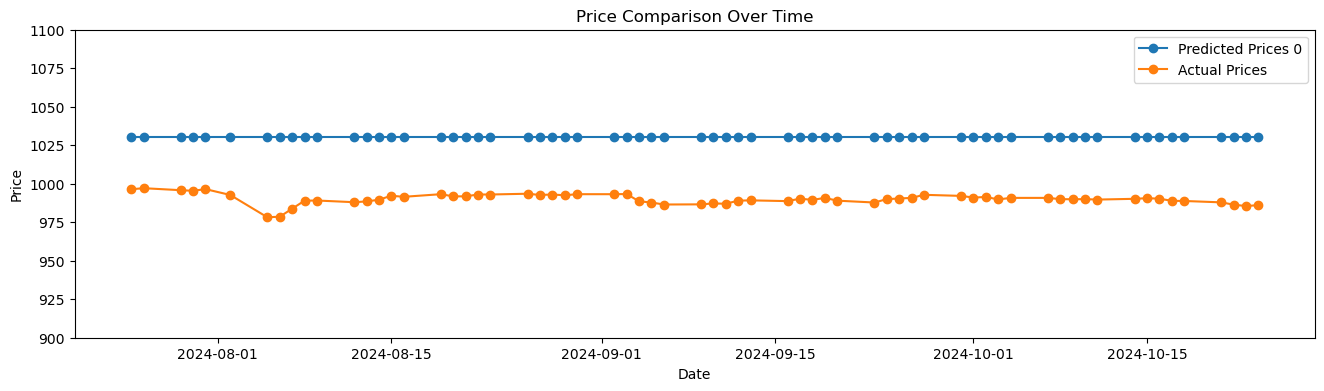

In [ ]:
evaluation_plot(
    backtest_start,
    backtest_end,
    combined_df,
    np.array(prices),
    ylim=(900, 1100)
)